In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../../data/data-cluster-examples-pause/explodingLiquid_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_2
Processing ../../data/data-cluster-examples-pause/explodingLiquid_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_2
Processing ../../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_1


# Load Data from Folders


In [3]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(180529, 30)

In [4]:
df.describe()

df.head(10)

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0             0.905797     3.0        93.75        78.75        68.75   
1             0.905797     3.0        93.75        78.75        68.75   
2             0.905797     3.0        93.75        78.75        68.75   
3             0.905797     3.0        93.75        78.75        68.75   
4             0.905797     3.0        93.75        78.75        68.75   
5             0.905797     3.0        93.75        78.75        68.75   
6             0.905797     3.0        93.75        78.75        68.75   
7             0.905797     3.0        93.75        78.75        68.75   
8             0.905797     3.0        93.75        78.75        68.75   
9             0.905797     3.0        93.75        78.75        68.75   

   estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                             85652     0.035863    0.107635   
1                             85652     0.035863    0.107635   
2                             85652     0.035863    0.107635   
3                             85652     0.035863    0.107635   
4                             85652     0.035863    0.107635   
5                             85652     0.035863    0.107635   
6                             85652     0.035863    0.107635   
7                             85652     0.035863    0.107635   
8                             85652     0.035863    0.107635   
9                             85652     0.035863    0.107635   

   maxParticlesPerCell  minParticlesPerCell  ...  threadCount    Container  \
0                    8                    0  ...           12  LinkedCells   
1                    8                    0  ...           12  LinkedCells   
2                    8                    0  ...           12  LinkedCells   
3                    8                    0  ...           12  LinkedCells   
4                    8                    0  ...           12  LinkedCells   
5                    8                    0  ...           12  LinkedCells   
6                    8                    0  ...           12  LinkedCells   
7                    8                    0  ...           12  LinkedCells   
8                    8                    0  ...           12  LinkedCells   
9                    8                    0  ...           12  LinkedCells   

   CellSizeFactor  Traversal  Load Estimator  Data Layout  Newton 3  \
0             1.0     lc_c01            none          AoS  disabled   
1             1.0     lc_c01            none          SoA  disabled   
2             1.0     lc_c04            none          AoS  disabled   
3             1.0     lc_c04            none          AoS   enabled   
4             1.0     lc_c04            none          SoA  disabled   
5             1.0     lc_c04            none          SoA   enabled   
6             1.0     lc_c08            none          AoS  disabled   
7             1.0     lc_c08            none          AoS   enabled   
8             1.0     lc_c08            none          SoA  disabled   
9             1.0     lc_c08            none          SoA   enabled   

      Reduced    Smoothed  Container_DataLayout  
0  22964350.0  22964350.0       LinkedCells_AoS  
1  21511665.0  21511665.0       LinkedCells_SoA  
2  19633948.0  19633948.0       LinkedCells_AoS  
3  13421045.0  13421045.0       LinkedCells_AoS  
4  20298967.0  20298967.0       LinkedCells_SoA  
5  14474746.0  14474746.0       LinkedCells_SoA  
6  19792369.0  19792369.0       LinkedCells_AoS  
7  13082756.0  13082756.0       LinkedCells_AoS  
8  19870901.0  19870901.0       LinkedCells_SoA  
9  13517639.0  13517639.0       LinkedCells_SoA  

[10 rows x 30 columns]

In [5]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [36]:
inputs = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    "Container",
    "Data Layout",
    "CellSizeFactor",
    "Traversal",
    "Load Estimator",
    "Newton 3",
]

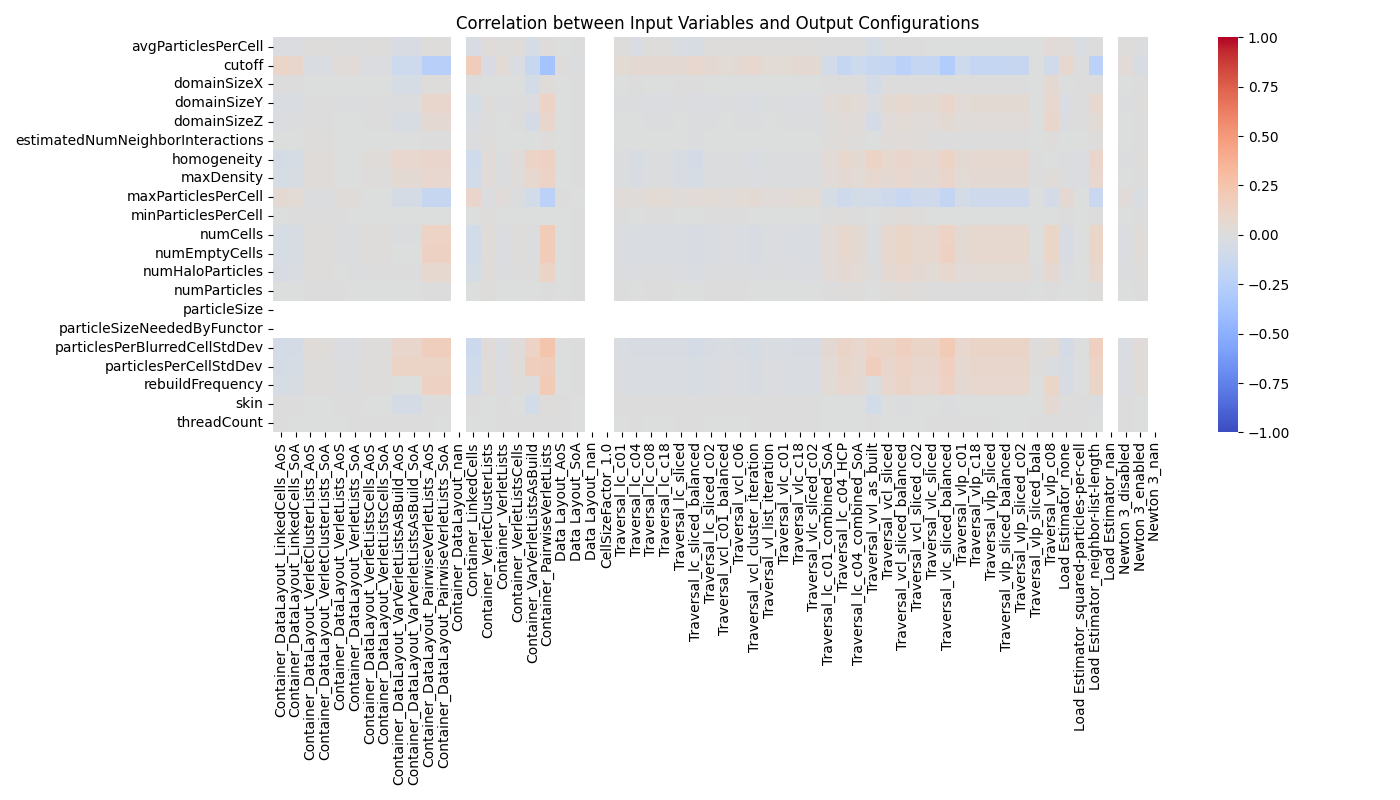


Correlations for Container_DataLayout_LinkedCells_AoS:
cutoff                              0.108404
maxParticlesPerCell                 0.059485
skin                                0.003642
domainSizeX                         0.001412
threadCount                         0.000033
minParticlesPerCell                -0.001071
numParticles                       -0.002793
estimatedNumNeighborInteractions   -0.005937
domainSizeZ                        -0.017656
avgParticlesPerCell                -0.017660
domainSizeY                        -0.030316
numHaloParticles                   -0.031575
maxDensity                         -0.049061
numCells                           -0.049594
numEmptyCells                      -0.050462
rebuildFrequency                   -0.052176
particlesPerCellStdDev             -0.060279
homogeneity                        -0.060281
particlesPerBlurredCellStdDev      -0.074999
particleSize                             NaN
particleSizeNeededByFunctor              NaN

In [40]:
# 1. Prepare the data
# Encode categorical output variables
le = LabelEncoder()
encoded_outputs = []
for col in outputs:
    df[col + '_encoded'] = le.fit_transform(df[col])
    for category in df[col].unique():
        df[f'{col}_{category}'] = (df[col] == category).astype(int)
        encoded_outputs.append(f'{col}_{category}')


# Combine input variables with encoded outputs
correlation_data = df[inputs + encoded_outputs]

# 2. Calculate correlations
correlation_matrix = correlation_data.corr()

# 3. Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix.loc[inputs, encoded_outputs],
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            fmt='.2f')
plt.title('Correlation between Input Variables and Output Configurations')
plt.tight_layout()
plt.show()

# Display correlation values
for output in encoded_outputs:
    print(f"\nCorrelations for {output}:")
    print(correlation_matrix[output][inputs].sort_values(ascending=False))

# Define Interesting Data to observe


In [6]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "Container",
    # "Data Layout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [7]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

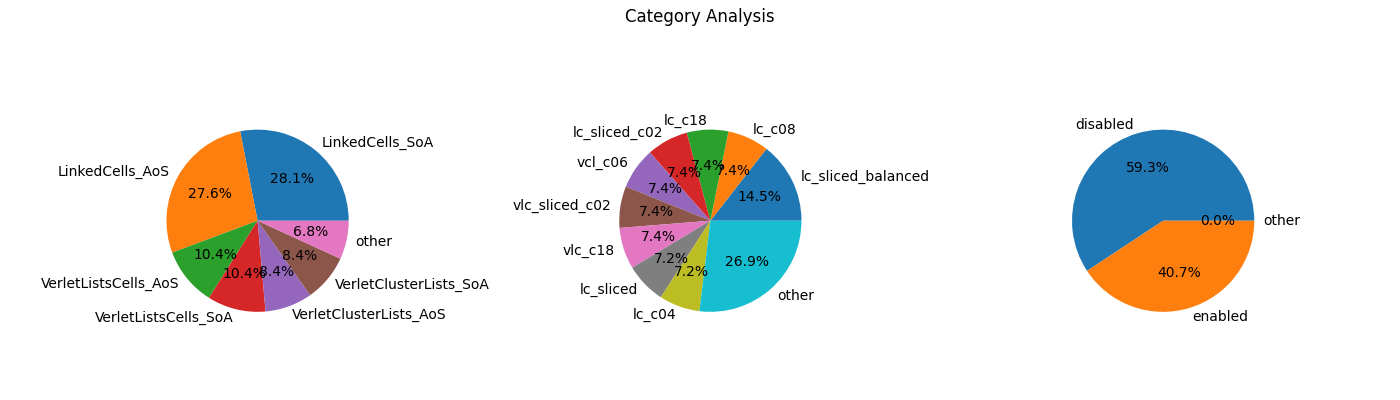

In [8]:
# Row 2
fig, ax1 = plt.subplots(1, len(outputs), figsize=(16, 4))
fig.suptitle("Category Analysis")
fig.set_figwidth(14)
fig.tight_layout(pad=3.0)

#make pi chart for each output
for i, col in enumerate(outputs):
    #group everything below 10% into "other"
    data = df[col].value_counts(normalize=True)
    dataGt = data[data > 0.05]
    
    #add other category to data
    dataGt["other"] = data[data <= 0.05].sum()


    data = pd.concat([dataGt])
    ax1[i].pie(data, labels=data.index, autopct='%1.1f%%')





fig.savefig("traversal_pie_chart.png", dpi=300)

['Container_DataLayout_LinkedCells_AoS', 'Container_DataLayout_LinkedCells_SoA', 'Container_DataLayout_VerletClusterLists_AoS', 'Container_DataLayout_VerletClusterLists_SoA', 'Container_DataLayout_VerletLists_AoS', 'Container_DataLayout_VerletLists_SoA', 'Container_DataLayout_VerletListsCells_AoS', 'Container_DataLayout_VerletListsCells_SoA', 'Container_DataLayout_VarVerletListsAsBuild_AoS', 'Container_DataLayout_VarVerletListsAsBuild_SoA', 'Container_DataLayout_PairwiseVerletLists_AoS', 'Container_DataLayout_PairwiseVerletLists_SoA', 'Container_DataLayout_nan', 'Traversal_lc_c01', 'Traversal_lc_c04', 'Traversal_lc_c08', 'Traversal_lc_c18', 'Traversal_lc_sliced', 'Traversal_lc_sliced_balanced', 'Traversal_lc_sliced_c02', 'Traversal_vcl_c01_balanced', 'Traversal_vcl_c06', 'Traversal_vcl_cluster_iteration', 'Traversal_vl_list_iteration', 'Traversal_vlc_c01', 'Traversal_vlc_c18', 'Traversal_vlc_sliced_c02', 'Traversal_lc_c01_combined_SoA', 'Traversal_lc_c04_HCP', 'Traversal_lc_c04_combine

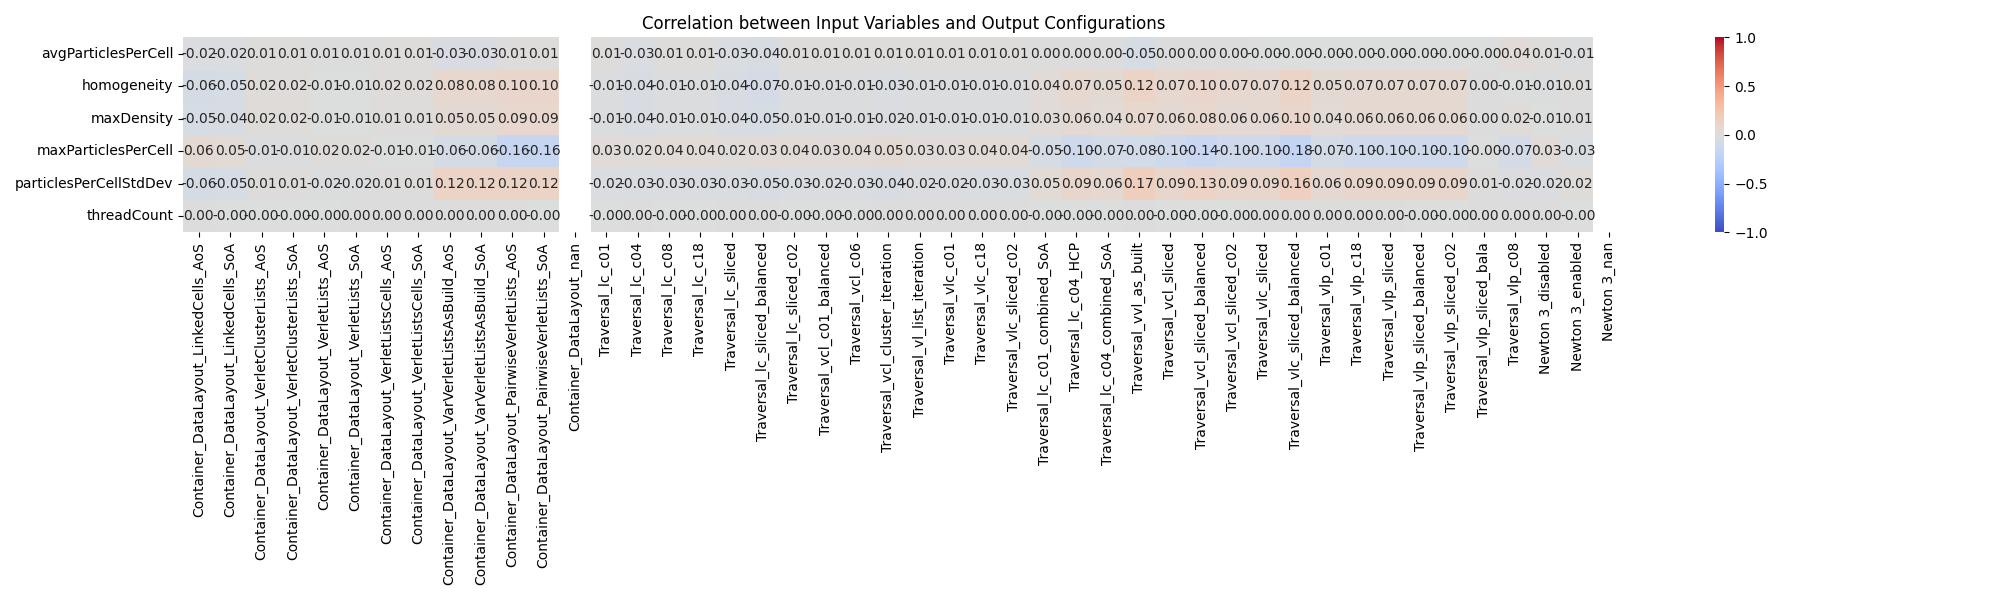


Correlations for Container_DataLayout_LinkedCells_AoS:
maxParticlesPerCell       0.059485
threadCount               0.000033
avgParticlesPerCell      -0.017660
maxDensity               -0.049061
particlesPerCellStdDev   -0.060279
homogeneity              -0.060281
Name: Container_DataLayout_LinkedCells_AoS, dtype: float64

Correlations for Container_DataLayout_LinkedCells_SoA:
maxParticlesPerCell       0.046299
threadCount              -0.000037
avgParticlesPerCell      -0.017268
maxDensity               -0.041349
particlesPerCellStdDev   -0.048509
homogeneity              -0.050968
Name: Container_DataLayout_LinkedCells_SoA, dtype: float64

Correlations for Container_DataLayout_VerletClusterLists_AoS:
homogeneity               0.020621
maxDensity                0.016596
particlesPerCellStdDev    0.014066
avgParticlesPerCell       0.013030
threadCount              -0.000266
maxParticlesPerCell      -0.010460
Name: Container_DataLayout_VerletClusterLists_AoS, dtype: float64

Correlatio

In [9]:
SPEEDUP_CUT = 0.7

group_by = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]


# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df.groupby(group_by)


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = grouped.apply(
    add_Speedup_column).reset_index(drop=True)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


def filter_groups(group):
    return group[group['speedup'] > SPEEDUP_CUT]

 # only keep rows where best_smoothed/current_smoothed is above 0.7
filtered_groups = grouped_speedup.groupby(
    group_by).apply(filter_groups).reset_index(drop=True)


print("Filtered length", len(filtered_groups))


def unique_string_elems(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# Combine all string columns into unique values
combined = filtered_groups.groupby(inputs).agg(
    unique_string_elems).reset_index()

print("Combined length", len(combined))

Orignal length 180529


/tmp/ipykernel_70285/2307988425.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speedup = grouped.apply(
/tmp/ipykernel_70285/2307988425.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_by).apply(filter_groups).reset_index(drop=True)


Filtered length 26896
Combined length 3212


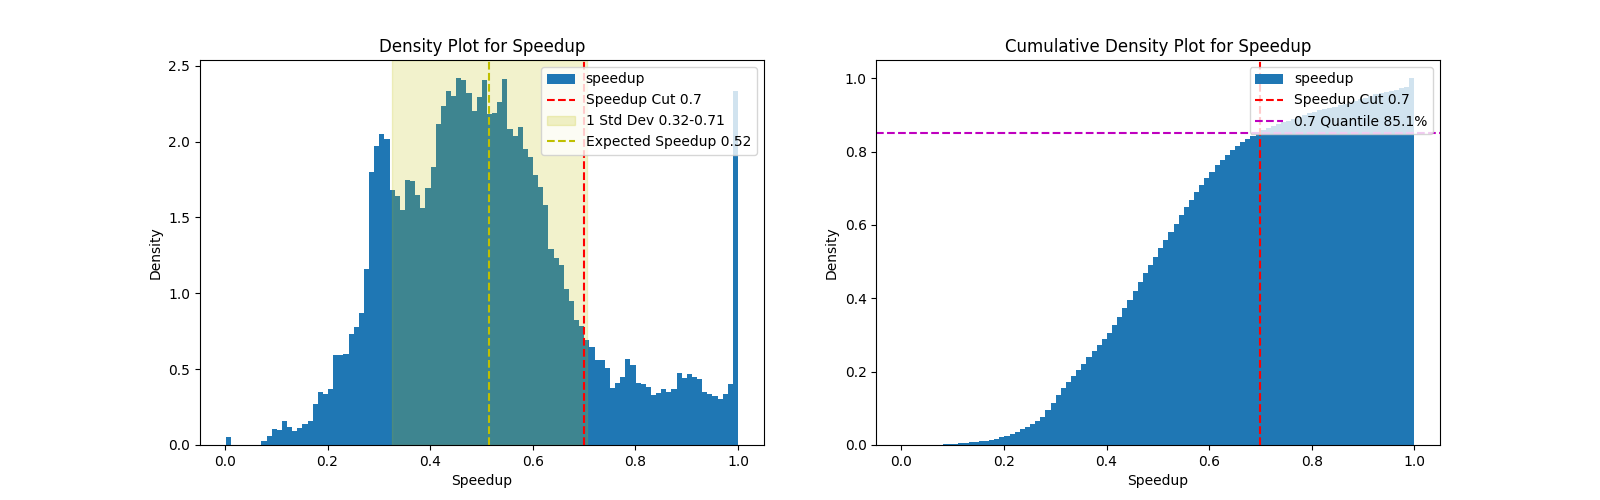

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# relative performance
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[0], density=True)
ax[0].set_title("Density Plot for Speedup")
ax[0].set_xlabel("Speedup")
ax[0].set_ylabel("Density")
ax[0].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {SPEEDUP_CUT}")

expectation = grouped_speedup["speedup"].mean()
std_dev = grouped_speedup["speedup"].std()

ax[0].axvspan(expectation-std_dev, expectation+std_dev, color='y', alpha=0.2,
              label=f"1 Std Dev {np.round(expectation-std_dev, 2)}-{np.round(expectation+std_dev, 2)}")

ax[0].axvline(x=expectation, color='y', linestyle='--',
              label=f"Expected Speedup {np.round(expectation, 2)}")

ax[0].legend(loc='upper right')

# cummulative distribution
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[1], density=True, cumulative=True)
ax[1].set_title("Cumulative Density Plot for Speedup")
ax[1].set_xlabel("Speedup")
ax[1].set_ylabel("Density")
ax[1].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {np.round(SPEEDUP_CUT, 2)}")

value_at_top_performance = 1-len(filtered_groups) / len(df)

ax[1].axhline(y=value_at_top_performance, color='m',
              linestyle='--', label=f"{SPEEDUP_CUT} Quantile {np.round(100*value_at_top_performance, 2)}%")
ax[1].legend(loc='upper right')

# Filter Data / Outliers


In [11]:
Z_THRESHHOLD = 1000
for column in inputs:
    z = np.abs(stats.zscore(combined[column]))
    combined = combined[z < Z_THRESHHOLD]

print("Outliers removed length", len(combined))


# filter values occuring less than pct
SPARSE_CUTOFF = 0.01
for column in outputs:
    counts = combined[column].value_counts()

    sparse_values = combined[column].isin(
        counts[counts > len(combined) * SPARSE_CUTOFF].index)

    combined = combined[sparse_values]


print("Sparse values removed length", len(combined))

X, y = combined[inputs], combined[outputs]
print(X.shape, y.shape)

Outliers removed length 3212
Sparse values removed length 2716
(2716, 6) (2716, 3)


# Create Train and Test Data


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [13]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
2064             0.905797     0.055112    0.297891                   15   
2914             0.944637     0.084061    0.673320                   25   
2794             0.944637     0.083134    0.479880                   22   
1486             0.905797     0.041394    0.336900                   20   
1554             0.905797     0.042934    0.195048                   13   

      particlesPerCellStdDev  threadCount  \
2064                0.015171            4   
2914                0.039916           24   
2794                0.040607           12   
1486                0.013546           24   
1554                0.012013           28   

                                   Container_DataLayout  \
2064  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2914  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2794  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
1486       VerletClusterLists_SoA, VerletListsCells_AoS   
1554       VerletClusterLists_SoA, VerletListsCells_AoS   

                                              Traversal           Newton 3  
2064  lc_sliced, lc_sliced_balanced, lc_sliced_c02, ...            enabled  
2914  lc_c04, lc_c08, lc_sliced, lc_sliced_balanced,...  disabled, enabled  
2794  lc_c04, lc_c08, lc_sliced, lc_sliced_balanced,...            enabled  
1486          vcl_c06, vlc_c01, vlc_c18, vlc_sliced_c02  disabled, enabled  
1554          vcl_c06, vlc_c01, vlc_c18, vlc_sliced_c02  disabled, enabled

In [14]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

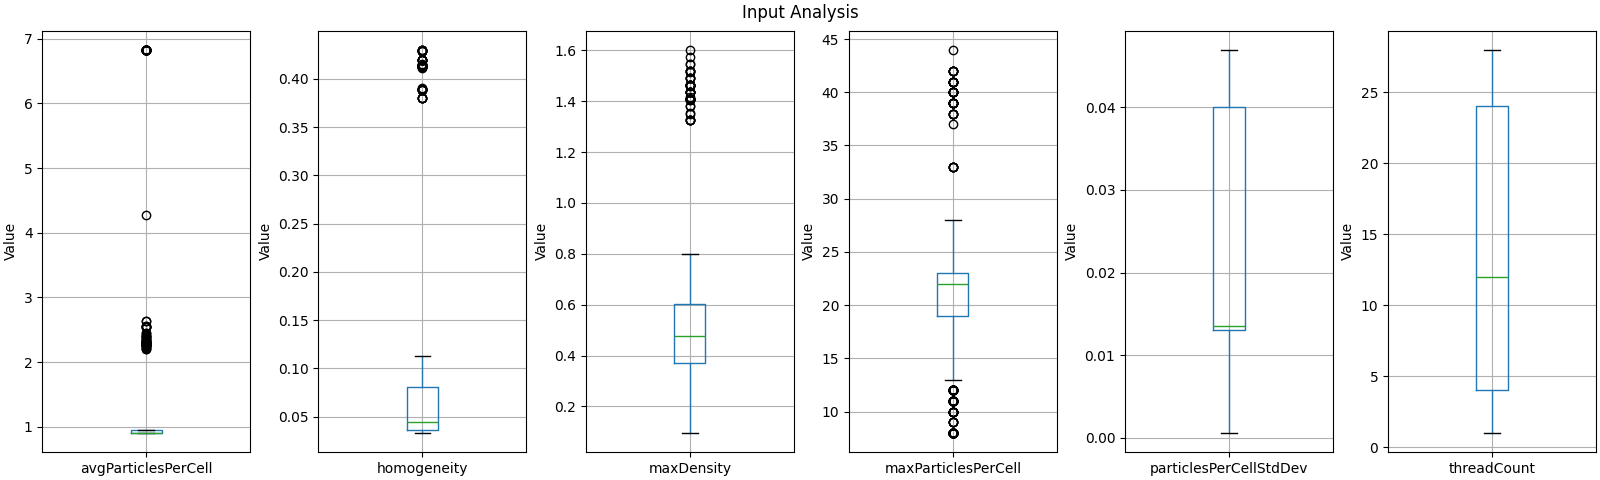

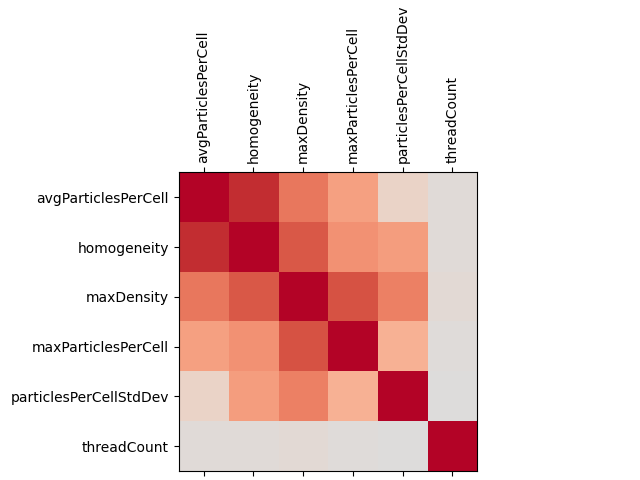

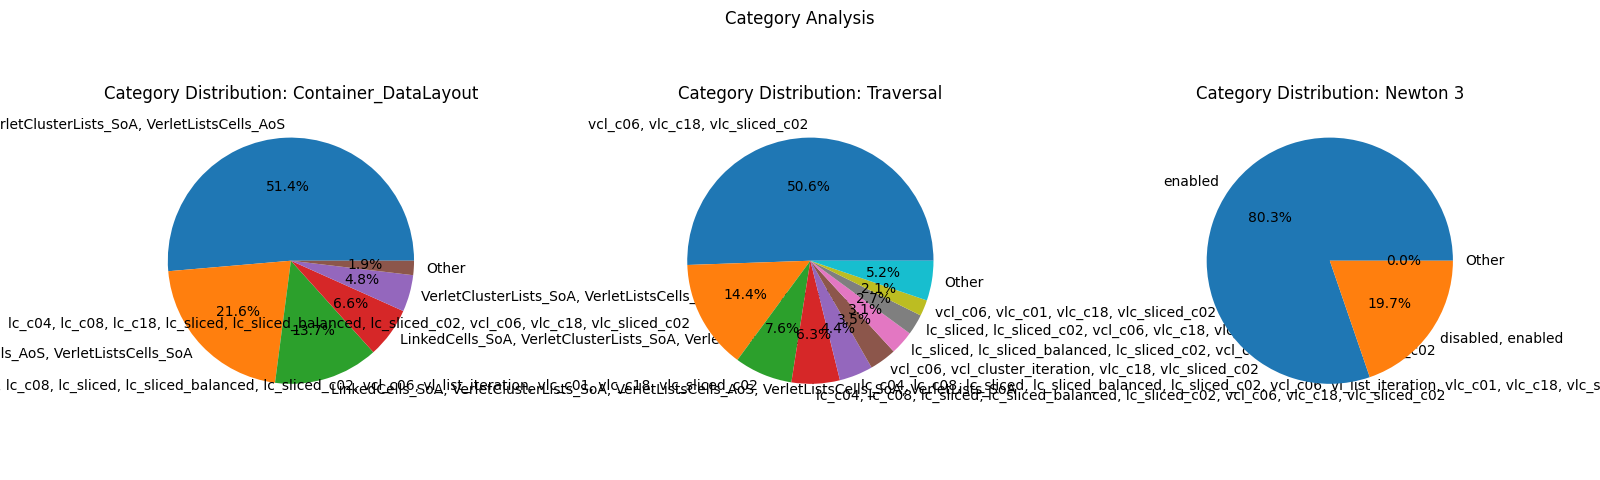

In [15]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns), constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix

fig.savefig("input_analysis.png",dpi=300)

fig, ax1 = plt.subplots(1, 1, constrained_layout=True)

corr = X.corr()
cax = ax1.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(X.columns)))
ax1.set_yticks(range(len(X.columns)))
ax1.set_xticklabels(X.columns, rotation=90)
ax1.set_yticklabels(X.columns)

fig.savefig("correlation_matrix.png",dpi=300)

# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")


fig.savefig("category_analysis.png",dpi=300)

/tmp/ipykernel_70285/4054552564.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


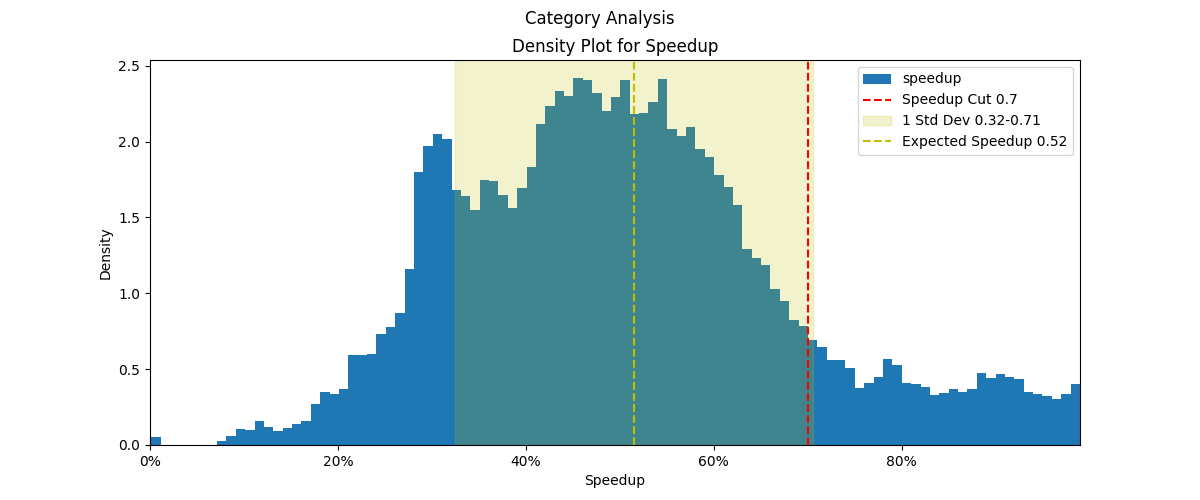

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
fig.suptitle("Category Analysis")
fig.set_figwidth(12)

# relative performance
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax, density=True)
ax.set_title("Density Plot for Speedup")
ax.set_xlabel("Speedup")
ax.set_ylabel("Density")
ax.axvline(x=SPEEDUP_CUT, color='r',
           linestyle='--', label=f"Speedup Cut {SPEEDUP_CUT}")

# set x axis to percent
ax.set_xlim(0, 0.99)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


expectation = grouped_speedup["speedup"].mean()
std_dev = grouped_speedup["speedup"].std()

ax.axvspan(expectation-std_dev, expectation+std_dev, color='y', alpha=0.2,
           label=f"1 Std Dev {np.round(expectation-std_dev, 2)}-{np.round(expectation+std_dev, 2)}")

ax.axvline(x=expectation, color='y', linestyle='--',
           label=f"Expected Speedup {np.round(expectation, 2)}")

ax.legend(loc='upper right')

fig.savefig("speedup.png", dpi=300)

# Train Decision Tree and Extract Rules


In [17]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.1,
    "Traversal": 0.08,
    "Newton 3": 0.02,
}

# maximum depth of the decision tree
MAX_DEPTH = 10

# how many models should be created for each label
TOP_K_MODELS_PER_LABEL = 2


Training on 2172 samples
Number of rules 50:
	Container_DataLayout (14 rules)
	Traversal (22 rules)
	Newton 3 (14 rules)


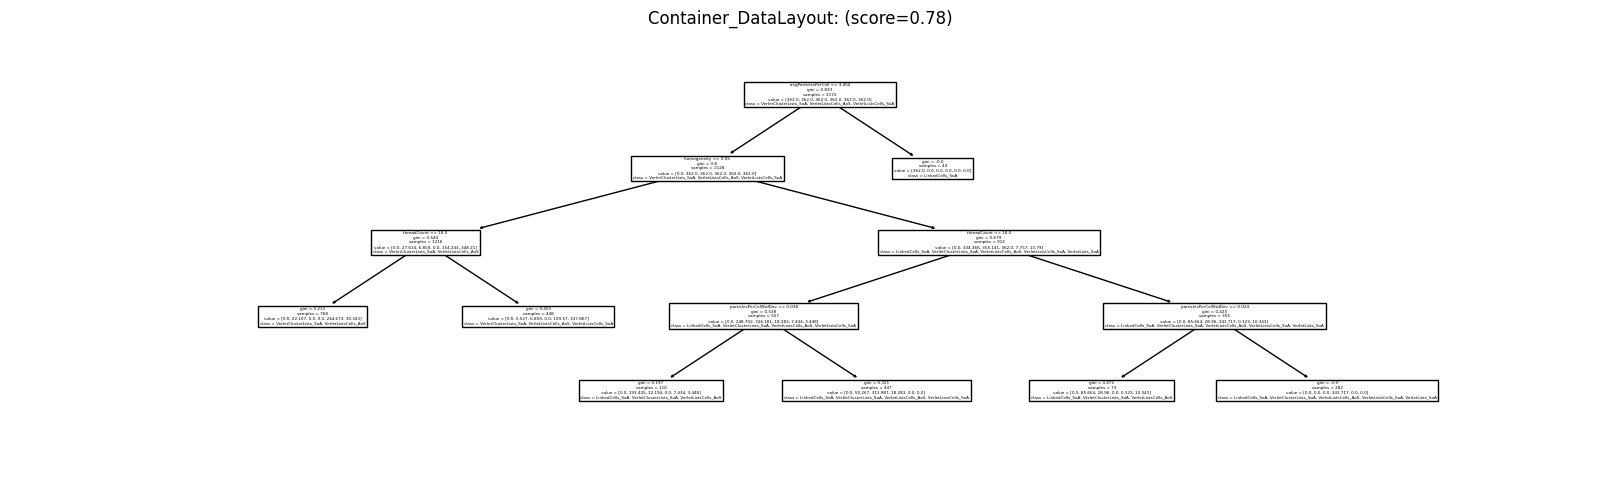

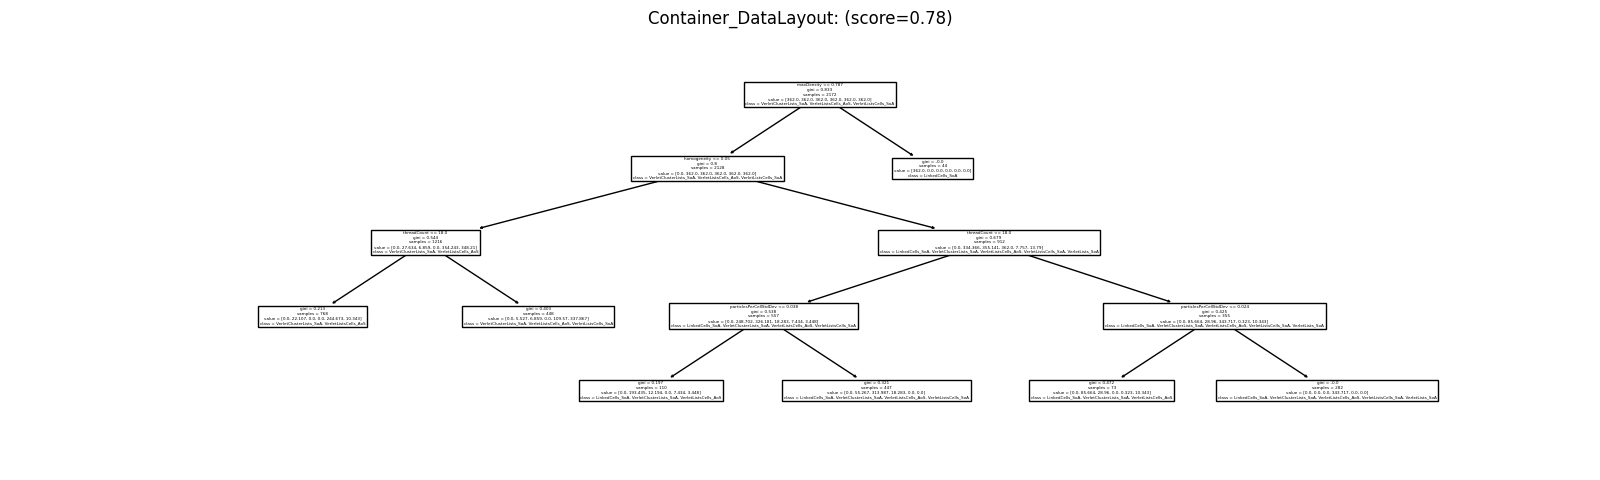

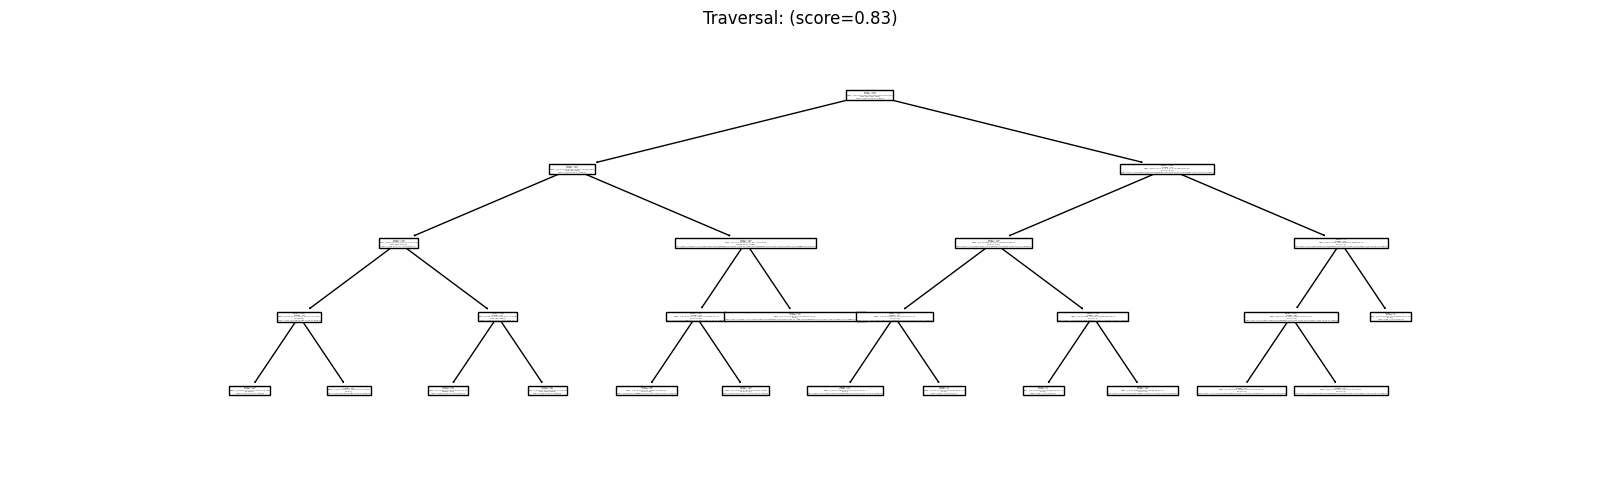

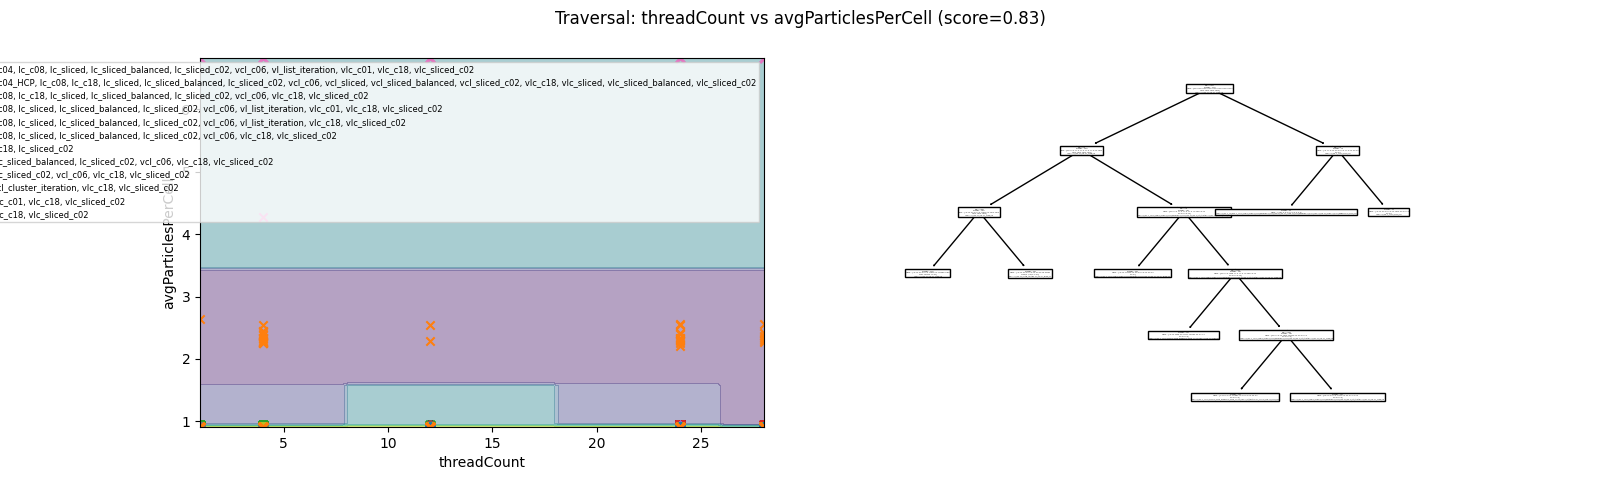

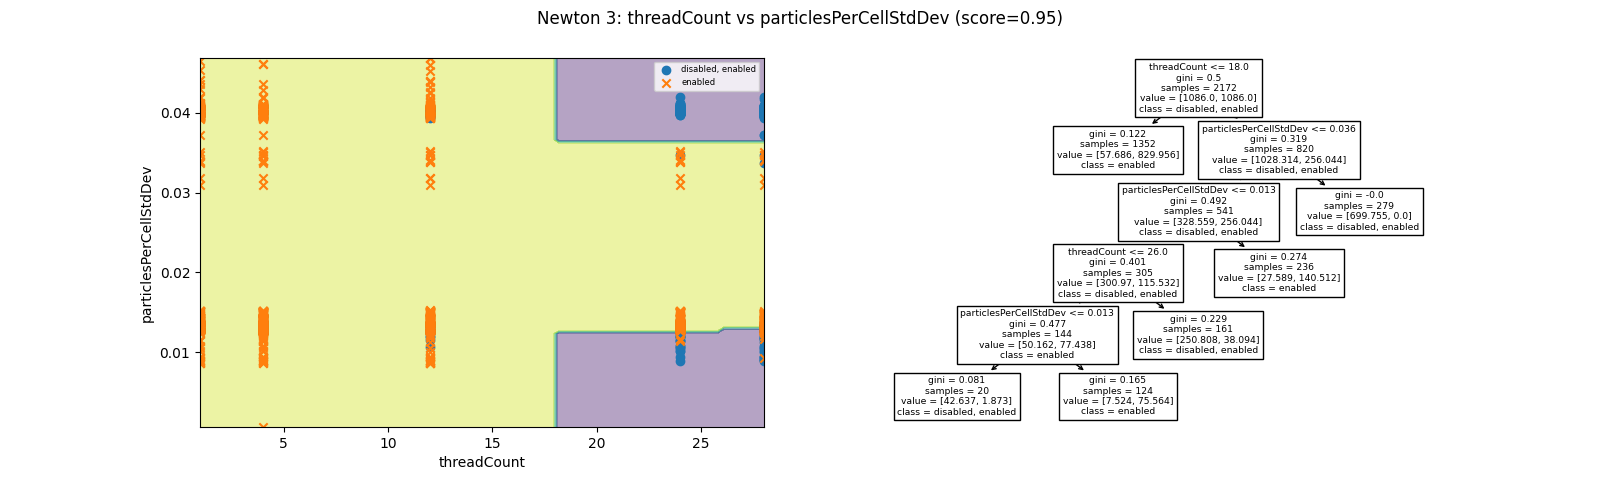

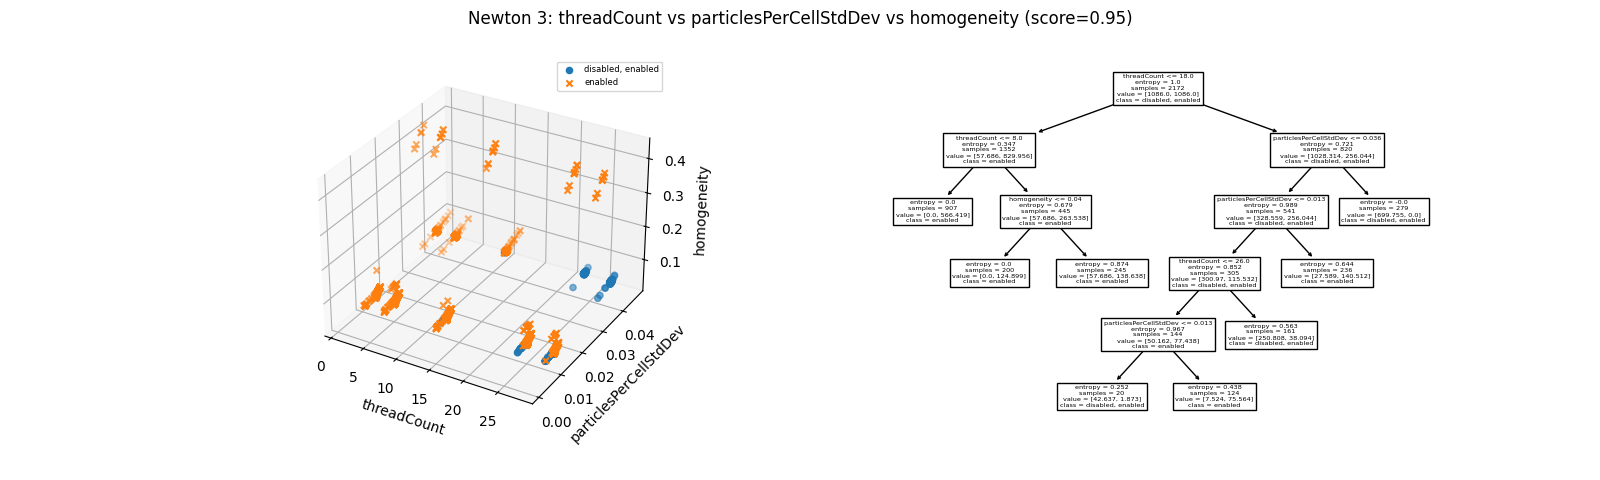

In [18]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manuel/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


avgParticlesPerCell: [-inf, 0.925, 1.553, 1.572, 3.454, inf]
avgParticlesPerCell: [-inf, 0.925, 1.553, 3.454, inf]

homogeneity: [-inf, 0.037, 0.04, 0.047, 0.05, 0.235, 0.242, inf]
homogeneity: [-inf, 0.037, 0.047, 0.235, inf]

threadCount: [-inf, 2.5, 8.0, 18.0, 26.0, inf]
threadCount: [-inf, 2.5, 8.0, 18.0, 26.0, inf]

particlesPerCellStdDev: [-inf, 0.013, 0.023, 0.024, 0.036, 0.037, 0.038, inf]
particlesPerCellStdDev: [-inf, 0.013, 0.023, 0.024, 0.036, 0.037, 0.038, inf]

maxDensity: [-inf, 0.787, inf]
maxDensity: [-inf, 0.787, inf]



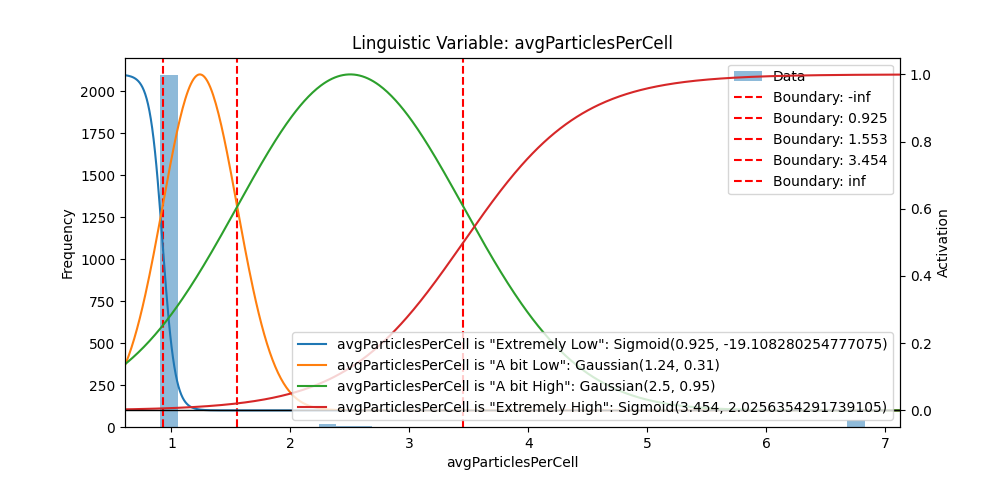

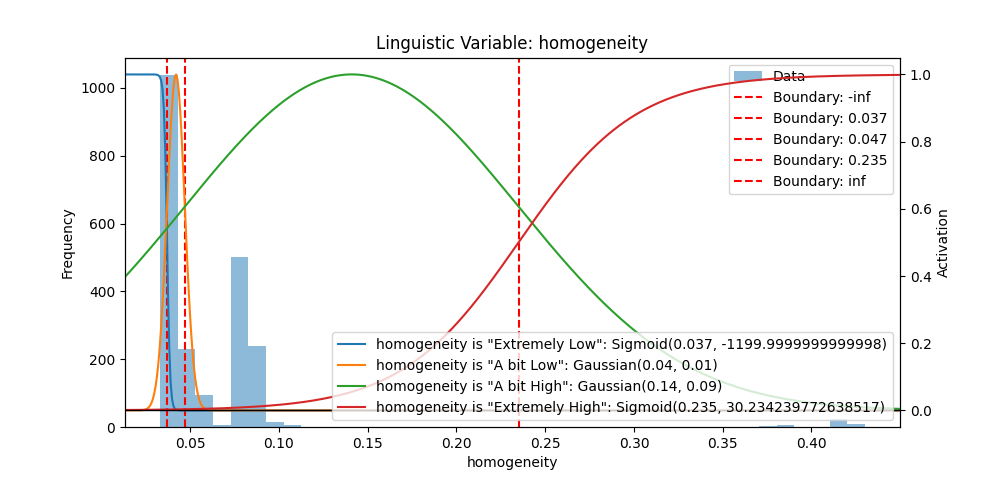

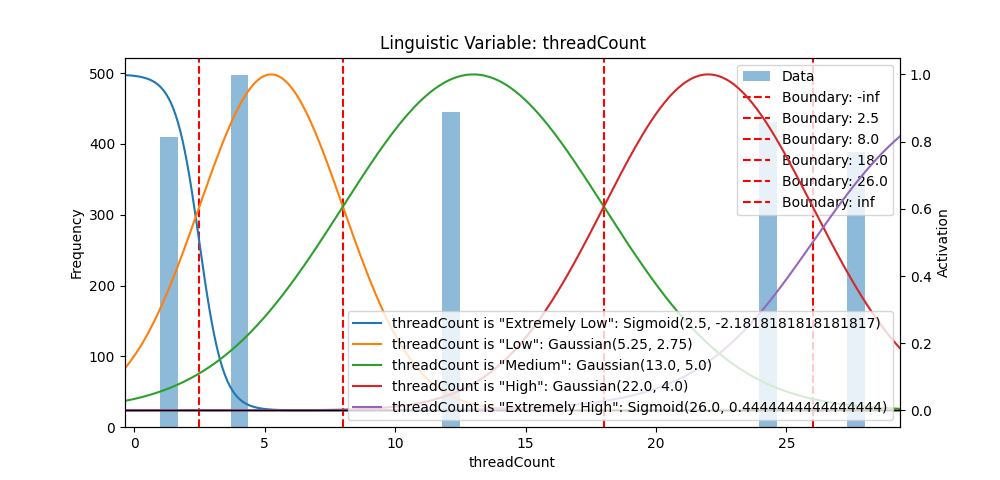

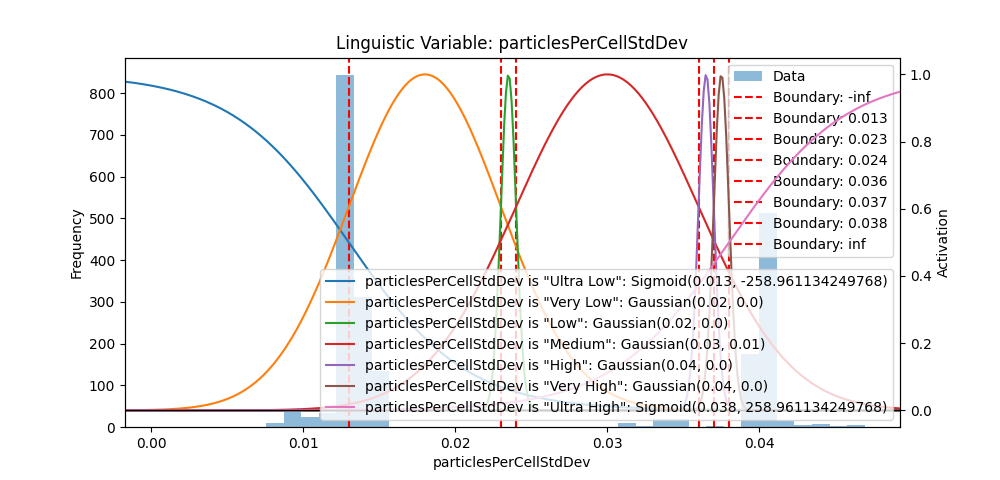

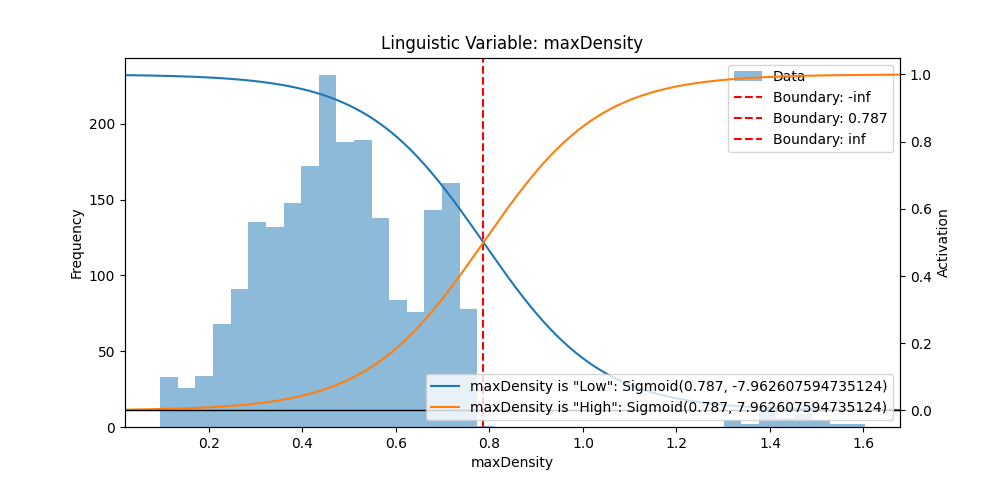

In [19]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/cluster-examples-pause/../rule_extraction.py:674: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(1, 1)


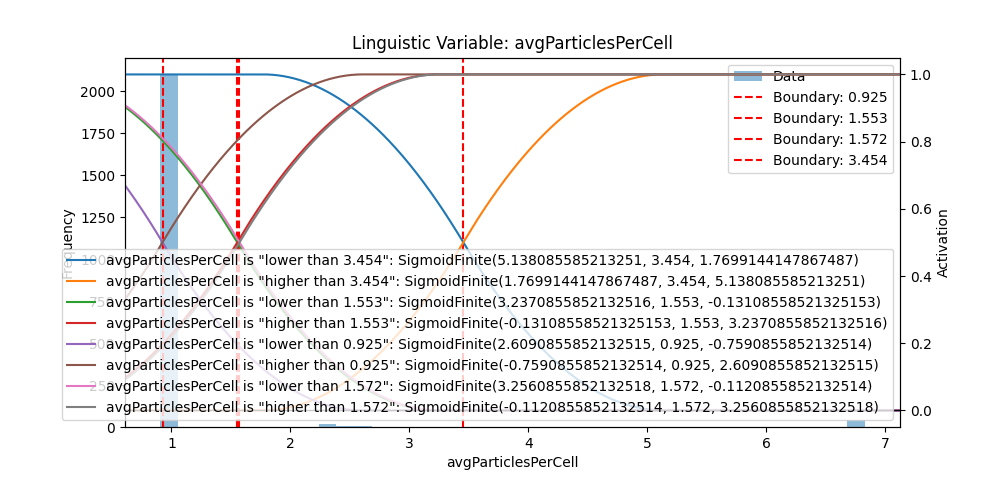

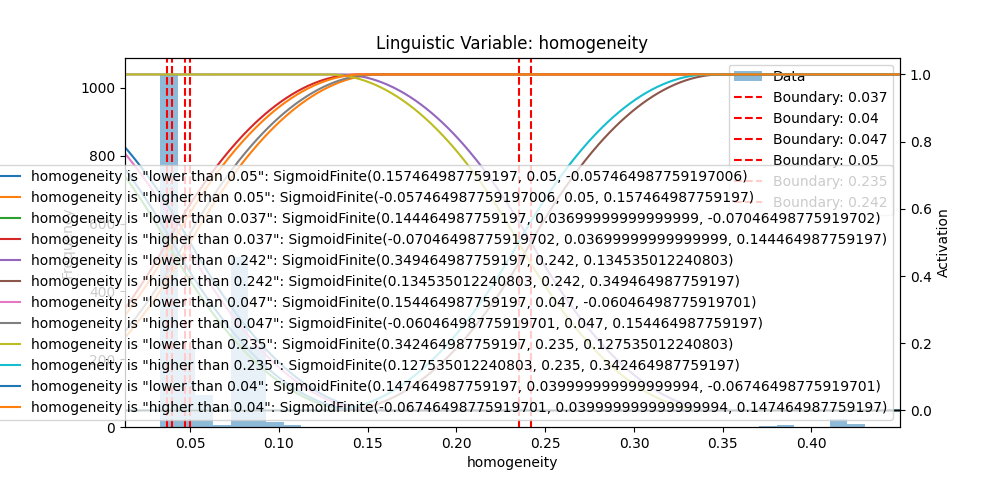

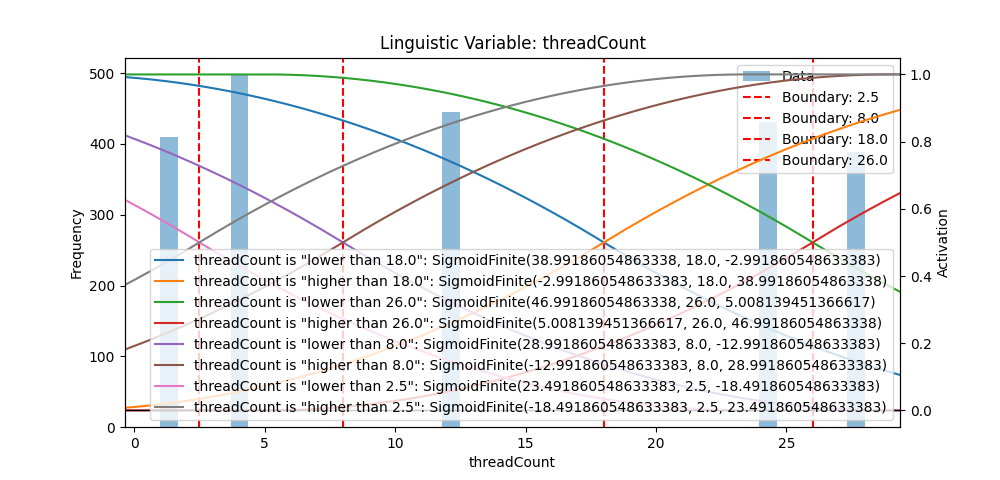

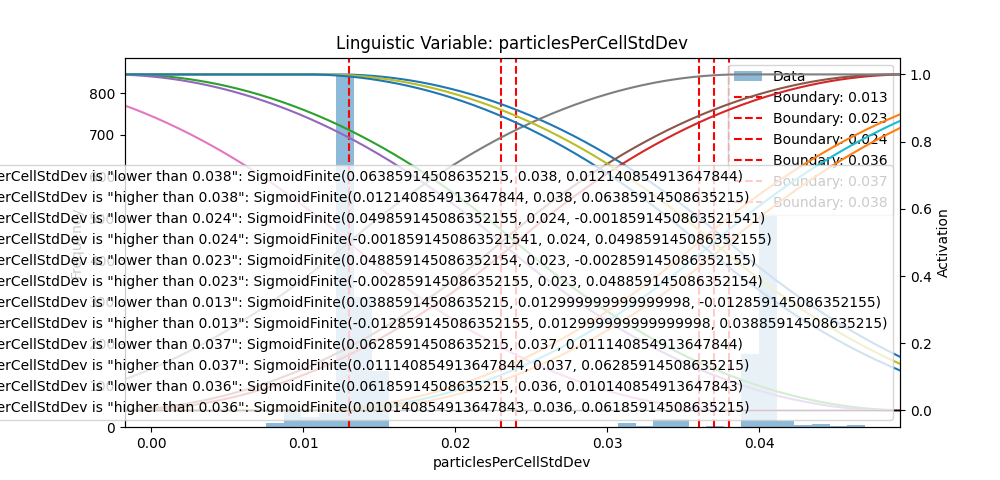

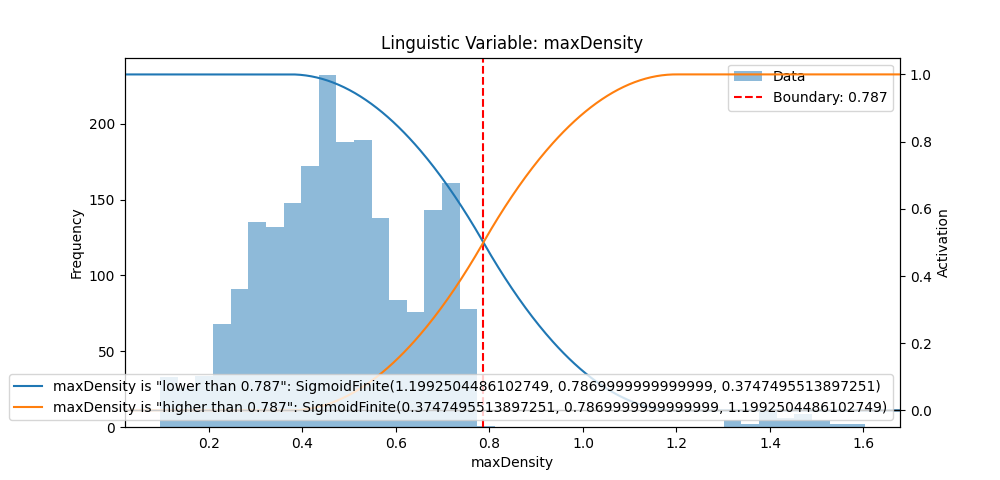

In [20]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

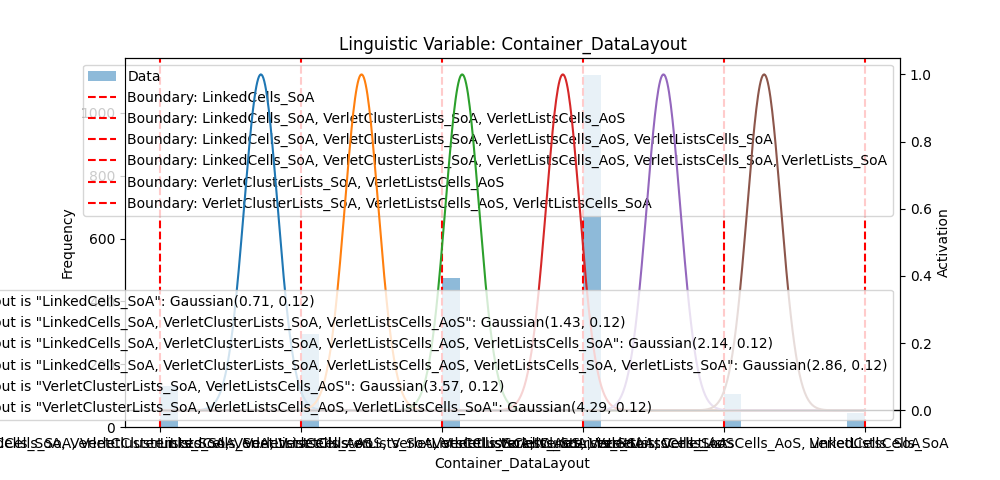

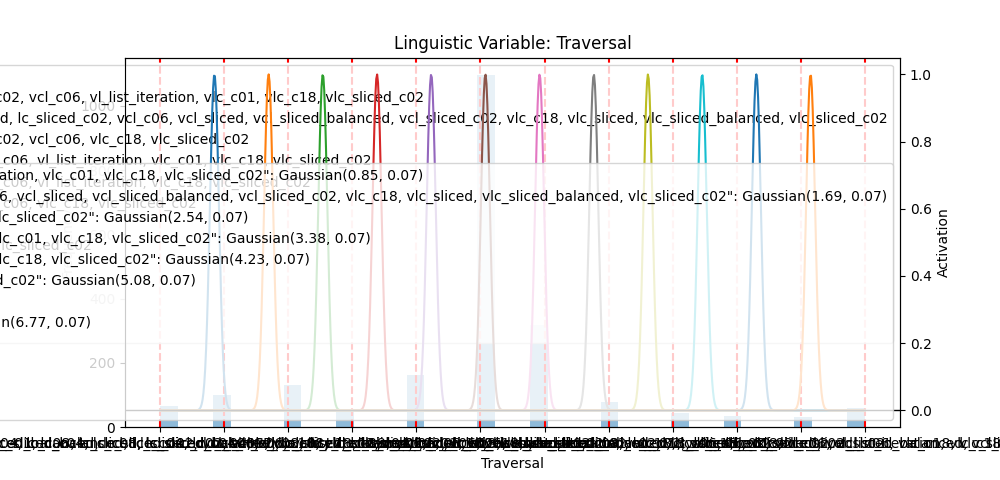

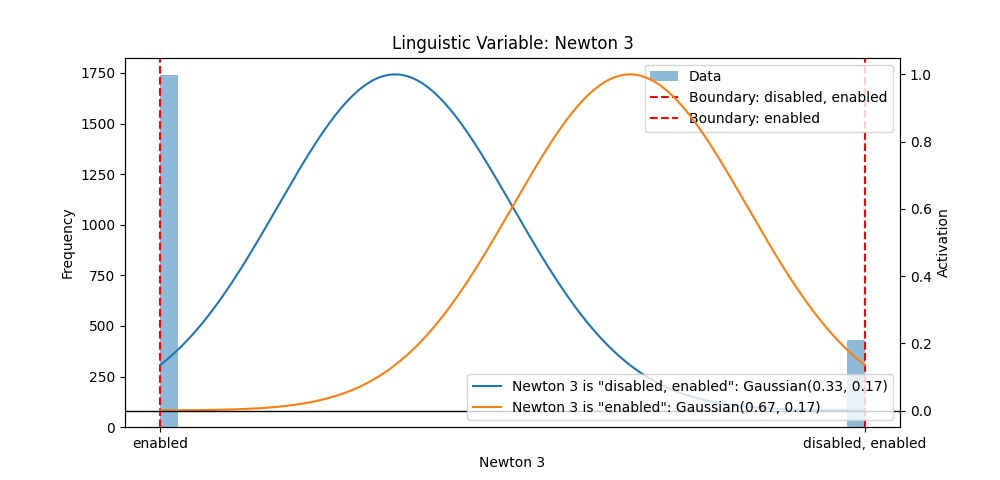

In [21]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

In [22]:
display(rules_to_table(rules_approach2, "Approach 2"))

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/cluster-examples-pause/../rule_extraction.py:939: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  table = table.applymap(
/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/cluster-examples-pause/../rule_extraction.py:942: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  table = table.applymap(


# Save all the data


In [23]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")